In [3]:
# ============================================
# EDA of Binance L2 Order Book Data (DOGEUSDT)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf

sns.set_style("whitegrid")

In [5]:
# -----------------------------
# 1. LOAD AND INITIAL INSPECTION
# -----------------------------
path = "D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
print("Columns:", df.columns[:10].tolist(), "...")
print(df.head())

# Ensure timestamps are numeric and sorted
df = df.sort_values("timestamp")
df["datetime"] = pd.to_datetime(df["timestamp"], unit="us")

Shape: (713815, 104)
Columns: ['exchange', 'symbol', 'timestamp', 'local_timestamp', 'asks[0].price', 'asks[0].amount', 'bids[0].price', 'bids[0].amount', 'asks[1].price', 'asks[1].amount'] ...
  exchange    symbol         timestamp   local_timestamp  asks[0].price  \
0  binance  DOGEUSDT  1735689601703988  1735689601703988        0.31601   
1  binance  DOGEUSDT  1735689601974000  1735689601975707        0.31601   
2  binance  DOGEUSDT  1735689602074000  1735689602075995        0.31601   
3  binance  DOGEUSDT  1735689602274000  1735689602275736        0.31601   
4  binance  DOGEUSDT  1735689602374000  1735689602375702        0.31601   

   asks[0].amount  bids[0].price  bids[0].amount  asks[1].price  \
0          126244          0.316           87917        0.31602   
1          126244          0.316           87917        0.31602   
2          126244          0.316           87917        0.31602   
3          115444          0.316           87917        0.31602   
4          115444   

In [6]:
print(df.head())

  exchange    symbol         timestamp   local_timestamp  asks[0].price  \
0  binance  DOGEUSDT  1735689601703988  1735689601703988        0.31601   
1  binance  DOGEUSDT  1735689601974000  1735689601975707        0.31601   
2  binance  DOGEUSDT  1735689602074000  1735689602075995        0.31601   
3  binance  DOGEUSDT  1735689602274000  1735689602275736        0.31601   
4  binance  DOGEUSDT  1735689602374000  1735689602375702        0.31601   

   asks[0].amount  bids[0].price  bids[0].amount  asks[1].price  \
0          126244          0.316           87917        0.31602   
1          126244          0.316           87917        0.31602   
2          126244          0.316           87917        0.31602   
3          115444          0.316           87917        0.31602   
4          115444          0.316           87917        0.31602   

   asks[1].amount  ...  bids[22].amount  asks[23].price  asks[23].amount  \
0           27345  ...            82614         0.31624            397

In [7]:
# -----------------------------
# 2. CLEANING & VALIDATION
# -----------------------------
# Drop duplicate timestamps if any
df = df.drop_duplicates(subset=["timestamp"]).reset_index(drop=True)

# Identify and drop obviously corrupted rows
mask_valid = df["asks[0].price"].notnull() & df["bids[0].price"].notnull()
df = df.loc[mask_valid]

# Check monotonicity of price ladders
def check_monotonic(df):
    ask_cols = [c for c in df.columns if re.search(r'asks\[\d+\]\.price', c)]
    bid_cols = [c for c in df.columns if re.search(r'bids\[\d+\]\.price', c)]
    ask_monotonic = (df[ask_cols].diff(axis=1).ge(0)).all(axis=1)
    bid_monotonic = (df[bid_cols].diff(axis=1).le(0)).all(axis=1)
    pct_invalid = 1 - ((ask_monotonic & bid_monotonic).mean())
    print(f"Non-monotonic snapshots: {pct_invalid*100:.2f}%")
    print("Shape:", df.shape)
check_monotonic(df)

Non-monotonic snapshots: 100.00%
Shape: (713815, 105)


In [8]:
# -----------------------------
# 3. BASIC METRICS
# -----------------------------
df["midprice"] = (df["asks[0].price"] + df["bids[0].price"]) / 2
df["spread"] = df["asks[0].price"] - df["bids[0].price"]
df["depth_top"] = df["asks[0].amount"] + df["bids[0].amount"]

print(df[["midprice", "spread", "depth_top"]].describe())

            midprice        spread     depth_top
count  713815.000000  7.138150e+05  7.138150e+05
mean        0.319243  1.000396e-05  1.595274e+05
std         0.003575  4.074235e-07  9.067493e+04
min         0.311955  1.000000e-05  4.300000e+01
25%         0.317145  1.000000e-05  1.209950e+05
50%         0.318425  1.000000e-05  1.505510e+05
75%         0.320105  1.000000e-05  1.840300e+05
max         0.327485  1.700000e-04  5.093532e+06


In [6]:
# -----------------------------
# 4. TICK SIZE INFERENCE
# -----------------------------
def infer_tick_size_from_l2(df, decimals=8):
    price_cols = [c for c in df.columns if re.search(r'(asks|bids)\[\d+\]\.price', c)]
    all_prices = np.concatenate([df[c].values for c in price_cols])
    diffs = np.diff(np.sort(np.unique(all_prices)))
    diffs = diffs[diffs > 0]
    tick = np.round(np.min(diffs), decimals)
    diag = pd.Series(diffs).value_counts().sort_index().head(10)
    return tick, diag

tick, diag = infer_tick_size_from_l2(df)
print(f"Inferred tick size: {tick}")
print(diag)

Inferred tick size: 1e-05
0.00001     288
0.00001    1314
Name: count, dtype: int64


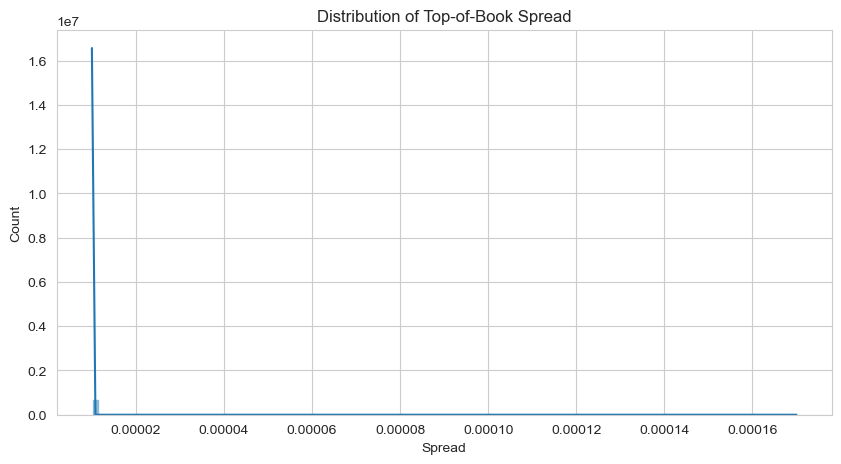

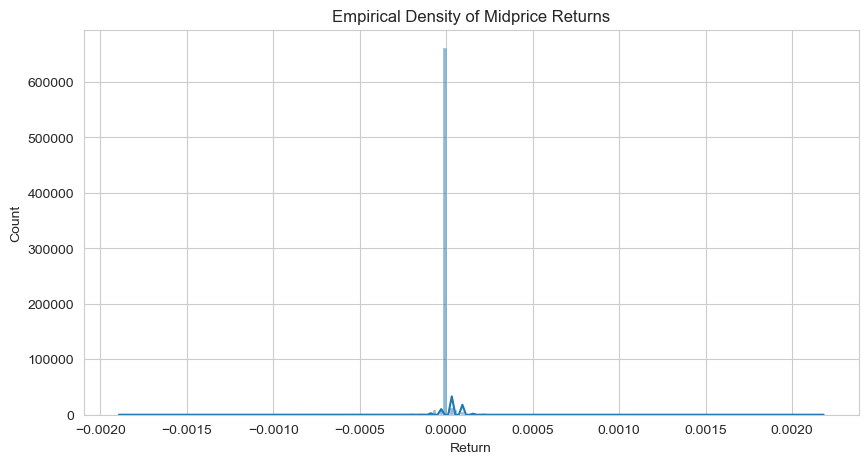

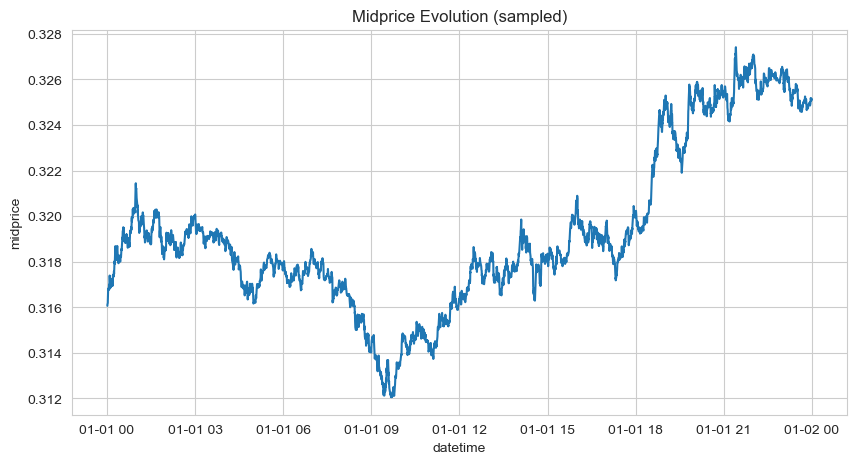

In [7]:
# -----------------------------
# 5. EMPIRICAL DISTRIBUTIONS
# -----------------------------
sns.set_style("whitegrid")

plt.figure(figsize=(10,5))
sns.histplot(df["spread"], bins=100, kde=True)
plt.title("Distribution of Top-of-Book Spread")
plt.xlabel("Spread")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["midprice"].pct_change().dropna(), bins=200, kde=True)
plt.title("Empirical Density of Midprice Returns")
plt.xlabel("Return")
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x="datetime", y="midprice", data=df.sample(n=5000))
plt.title("Midprice Evolution (sampled)")
plt.show()

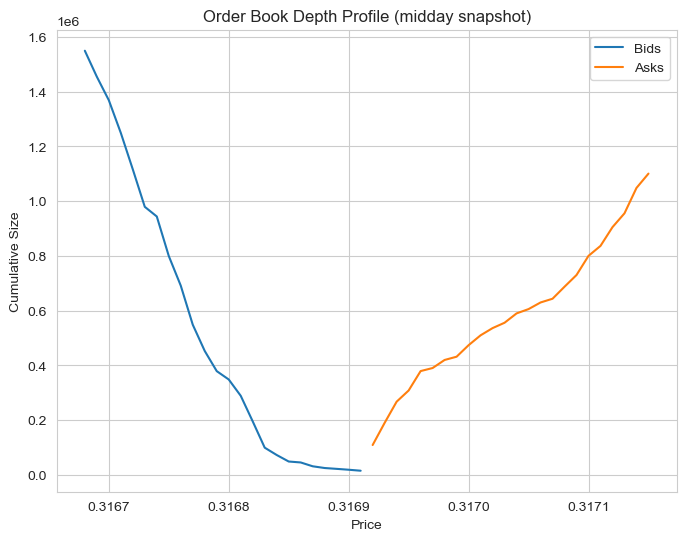

In [8]:
# -----------------------------
# 6. DEPTH PROFILE (SNAPSHOT)
# -----------------------------
snap = df.iloc[len(df)//2]  # middle of day snapshot
depth = pd.DataFrame({
    "ask_price": [snap[f"asks[{i}].price"] for i in range(24)],
    "ask_amount": [snap[f"asks[{i}].amount"] for i in range(24)],
    "bid_price": [snap[f"bids[{i}].price"] for i in range(24)],
    "bid_amount": [snap[f"bids[{i}].amount"] for i in range(24)],
})
depth = depth.sort_values("ask_price")

plt.figure(figsize=(8,6))
plt.plot(depth["bid_price"], depth["bid_amount"].cumsum(), label="Bids")
plt.plot(depth["ask_price"], depth["ask_amount"].cumsum(), label="Asks")
plt.title("Order Book Depth Profile (midday snapshot)")
plt.xlabel("Price")
plt.ylabel("Cumulative Size")
plt.legend()
plt.show()

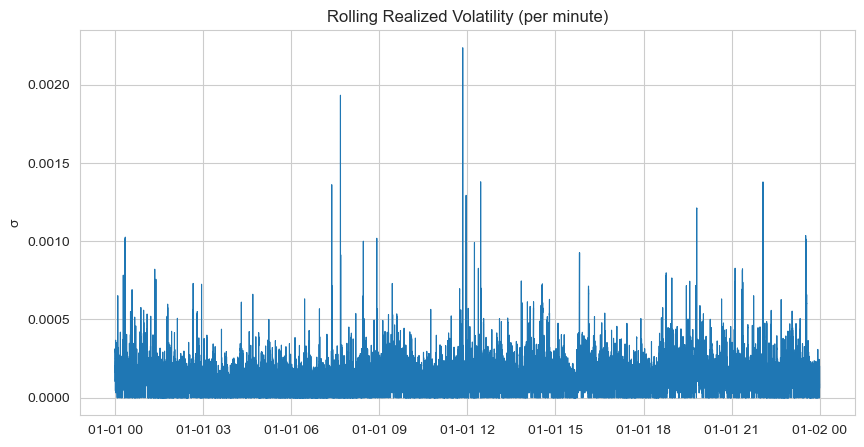

KeyboardInterrupt: 

In [9]:
# -----------------------------
# 7. TEMPORAL VOLATILITY ANALYSIS
# -----------------------------
df["return"] = df["midprice"].pct_change()
window = 60  # 60-second rolling window
df["volatility"] = df["return"].rolling(window).std() * np.sqrt(60)

plt.figure(figsize=(10,5))
plt.plot(df["datetime"], df["volatility"], linewidth=0.8)
plt.title("Rolling Realized Volatility (per minute)")
plt.ylabel("σ")
plt.show()

In [ ]:
# -----------------------------
# 8. SAVE CLEANED DATA
# -----------------------------
clean_path = "dogeusdt_l2_clean.csv"
df.to_csv(clean_path, index=False)
print(f"Saved cleaned data to {clean_path}")

In [12]:
# Assuming df already cleaned and has columns:
# ['timestamp', 'datetime', 'asks[0].price', 'asks[0].amount', 'bids[0].price', 'bids[0].amount', ...]

# -----------------------------
# 9. MICROSTRUCTURE METRICS
# -----------------------------

def compute_orderbook_imbalance(df, levels=5):
    """Compute top-N order book imbalance."""
    ask_vol = df[[f"asks[{i}].amount" for i in range(levels)]].sum(axis=1)
    bid_vol = df[[f"bids[{i}].amount" for i in range(levels)]].sum(axis=1)
    return (bid_vol - ask_vol) / (bid_vol + ask_vol)

def compute_weighted_midprice(df, levels=5):
    """Weighted midprice over top-N levels."""
    ask_price = df[[f"asks[{i}].price" for i in range(levels)]]
    bid_price = df[[f"bids[{i}].price" for i in range(levels)]]
    ask_vol = df[[f"asks[{i}].amount" for i in range(levels)]]
    bid_vol = df[[f"bids[{i}].amount" for i in range(levels)]]
    ask_wavg = (ask_price * ask_vol).sum(axis=1) / ask_vol.sum(axis=1)
    bid_wavg = (bid_price * bid_vol).sum(axis=1) / bid_vol.sum(axis=1)
    return (ask_wavg + bid_wavg) / 2

def compute_quote_slope(df, levels=5):
    """Quote slope: price-volume slope over top-N levels."""
    slopes = []
    for i in range(levels - 1):
        pa = df[f"asks[{i+1}].price"] - df[f"asks[{i}].price"]
        va = df[f"asks[{i+1}].amount"] - df[f"asks[{i}].amount"]
        pb = df[f"bids[{i}].price"] - df[f"bids[{i+1}].price"]
        vb = df[f"bids[{i}].amount"] - df[f"bids[{i+1}].amount"]
        slope = (va / pa.abs() + vb / pb.abs()) / 2
        slopes.append(slope)
    return np.nanmean(slopes, axis=0)

# Compute metrics
df["imbalance"] = compute_orderbook_imbalance(df, levels=5)
df["wmp"] = compute_weighted_midprice(df, levels=5)
df["quote_slope"] = compute_quote_slope(df, levels=5)

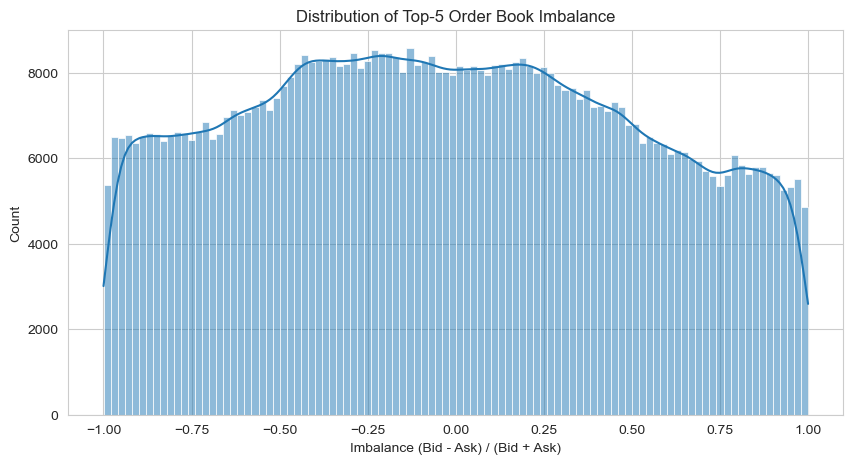

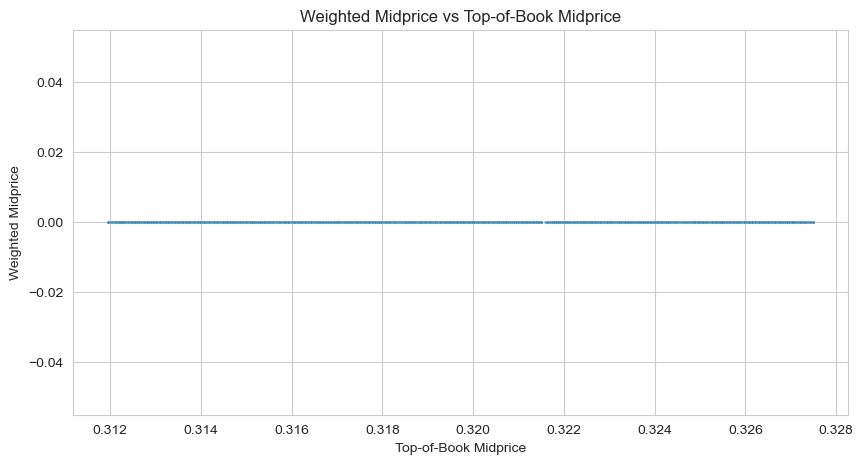

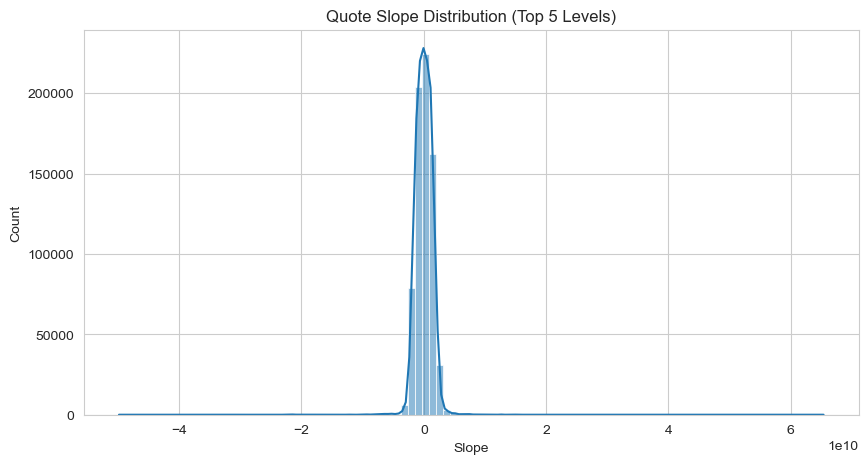

In [13]:
# -----------------------------
# 10. MICROSTRUCTURE INSIGHTS
# -----------------------------

# A) Imbalance distribution
plt.figure(figsize=(10,5))
sns.histplot(df["imbalance"], bins=100, kde=True)
plt.title("Distribution of Top-5 Order Book Imbalance")
plt.xlabel("Imbalance (Bid - Ask) / (Bid + Ask)")
plt.show()

# B) Weighted midprice vs top-of-book midprice
plt.figure(figsize=(10,5))
sns.scatterplot(x=df["midprice"], y=df["wmp"], s=3, alpha=0.3)
plt.title("Weighted Midprice vs Top-of-Book Midprice")
plt.xlabel("Top-of-Book Midprice")
plt.ylabel("Weighted Midprice")
plt.show()

# C) Quote slope distribution
plt.figure(figsize=(10,5))
sns.histplot(df["quote_slope"].dropna(), bins=100, kde=True)
plt.title("Quote Slope Distribution (Top 5 Levels)")
plt.xlabel("Slope")
plt.show()

Correlation between imbalance and future midprice change (h=10): 0.3786


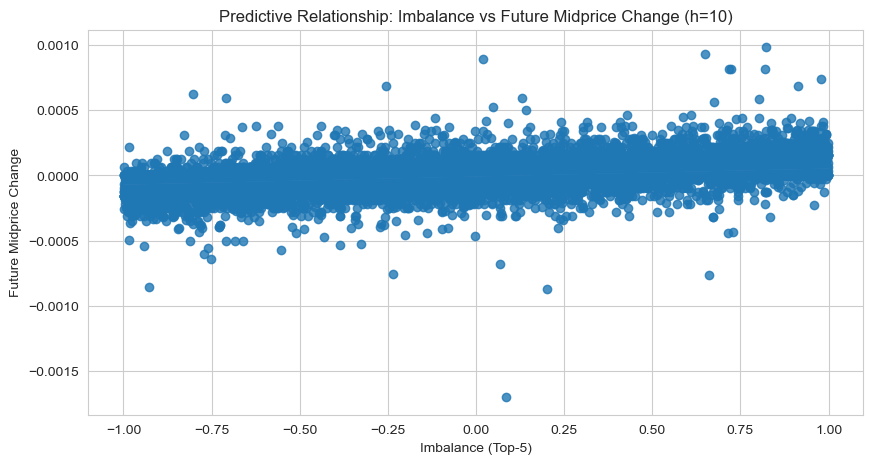

In [14]:
# -----------------------------
# 11. MIDPRICE IMPACT ANALYSIS
# -----------------------------
# How does imbalance predict future midprice change?

horizon = 10  # ticks ahead
df["future_mid"] = df["midprice"].shift(-horizon)
df["mid_change"] = df["future_mid"] / df["midprice"] - 1

valid = df.dropna(subset=["imbalance", "mid_change"])
corr, _ = pearsonr(valid["imbalance"], valid["mid_change"])
print(f"Correlation between imbalance and future midprice change (h={horizon}): {corr:.4f}")

plt.figure(figsize=(10,5))
sns.regplot(x="imbalance", y="mid_change", data=valid.sample(20000))
plt.title(f"Predictive Relationship: Imbalance vs Future Midprice Change (h={horizon})")
plt.xlabel("Imbalance (Top-5)")
plt.ylabel("Future Midprice Change")
plt.show()

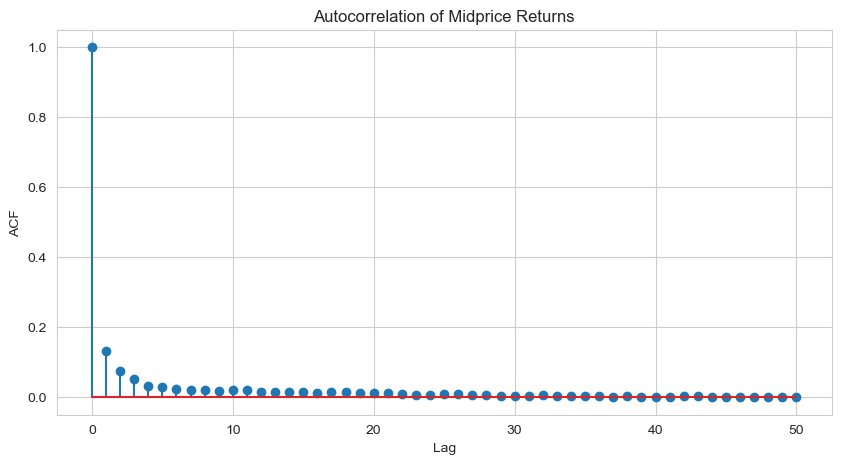

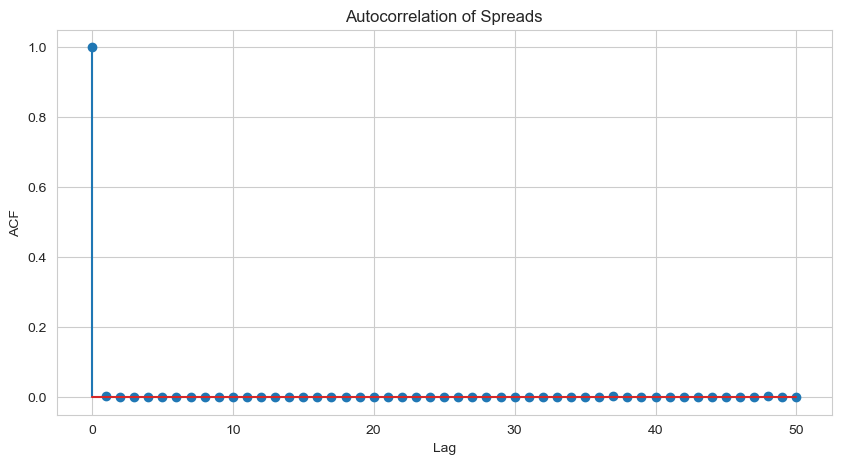

In [ ]:
# -----------------------------
# 12. AUTOCORRELATION STRUCTURE
# -----------------------------
returns = df["midprice"].pct_change().dropna()
spreads = df["spread"].dropna()

acf_returns = acf(returns, nlags=50, fft=True)
acf_spreads = acf(spreads, nlags=50, fft=True)

plt.figure(figsize=(10,5))
plt.stem(acf_returns)
plt.title("Autocorrelation of Midprice Returns")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

plt.figure(figsize=(10,5))
plt.stem(acf_spreads)
plt.title("Autocorrelation of Spreads")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

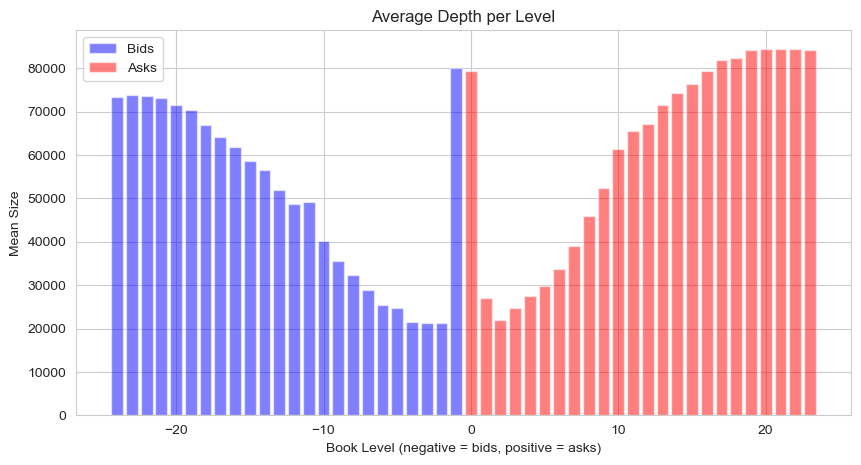

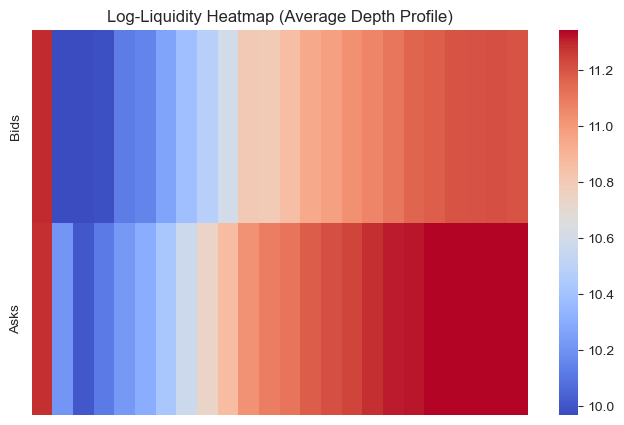

KeyboardInterrupt: 

In [17]:
# -----------------------------
# 13. LIQUIDITY HEATMAPS
# -----------------------------
# Aggregate average liquidity at each level across the day
ask_amounts = [f"asks[{i}].amount" for i in range(24)]
bid_amounts = [f"bids[{i}].amount" for i in range(24)]
avg_ask = df[ask_amounts].mean().values
avg_bid = df[bid_amounts].mean().values[::-1]  # reverse for plotting symmetry

plt.figure(figsize=(10,5))
plt.bar(np.arange(-24, 0), avg_bid, color="blue", alpha=0.5, label="Bids")
plt.bar(np.arange(0, 24), avg_ask, color="red", alpha=0.5, label="Asks")
plt.title("Average Depth per Level")
plt.xlabel("Book Level (negative = bids, positive = asks)")
plt.ylabel("Mean Size")
plt.legend()
plt.show()

# Heatmap of average price levels
ask_prices = df[[f"asks[{i}].price" for i in range(24)]].mean()
bid_prices = df[[f"bids[{i}].price" for i in range(24)]].mean()

heat_df = pd.DataFrame({
    "bid_price": bid_prices.values[::-1],
    "ask_price": ask_prices.values,
    "bid_size": avg_bid,
    "ask_size": avg_ask
})

plt.figure(figsize=(8,5))
sns.heatmap(
    np.log1p(np.vstack([avg_bid[::-1], avg_ask])),
    cmap="coolwarm", xticklabels=False, yticklabels=["Bids", "Asks"]
)
plt.title("Log-Liquidity Heatmap (Average Depth Profile)")
plt.show()

In [ ]:
# -----------------------------
# 14. SAVE EXTENDED METRICS
# -----------------------------
df.to_csv("dogeusdt_l2_clean_enriched.csv", index=False)
print("✅ Saved enriched dataset with microstructure metrics.")

Empirical Density & Statistical Diagnostic

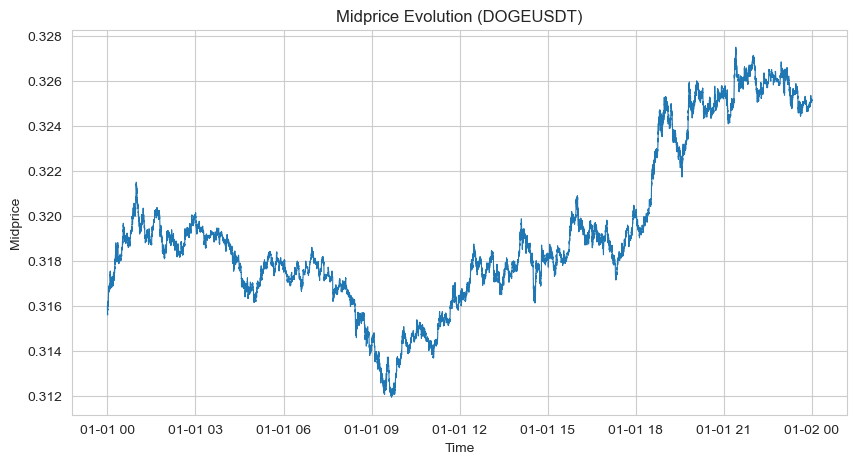

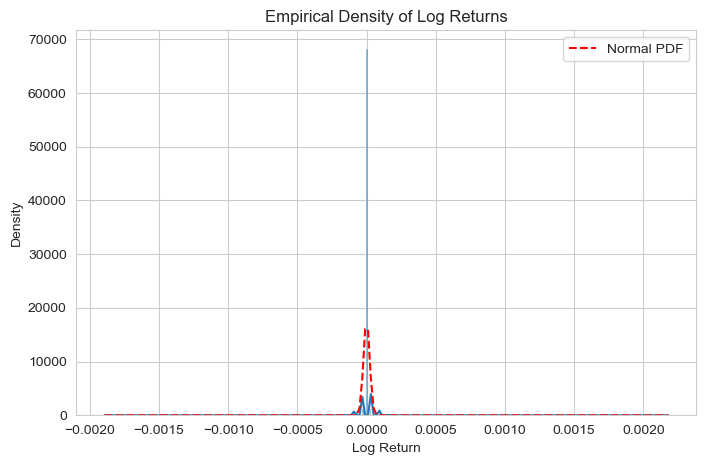

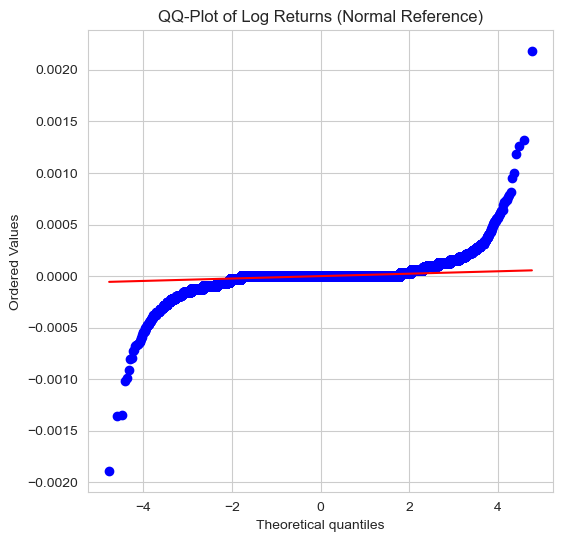

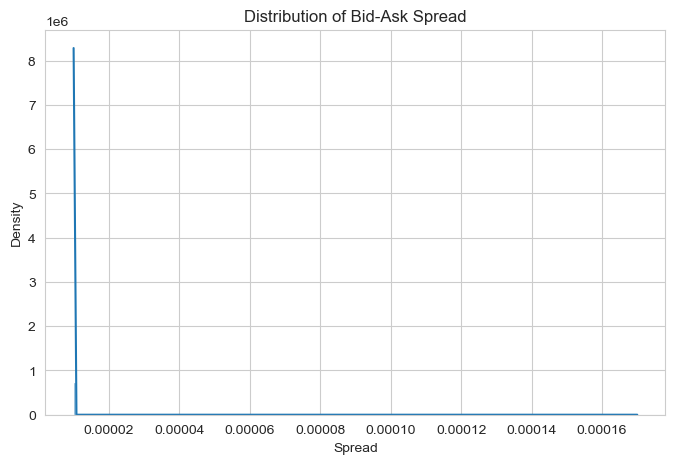

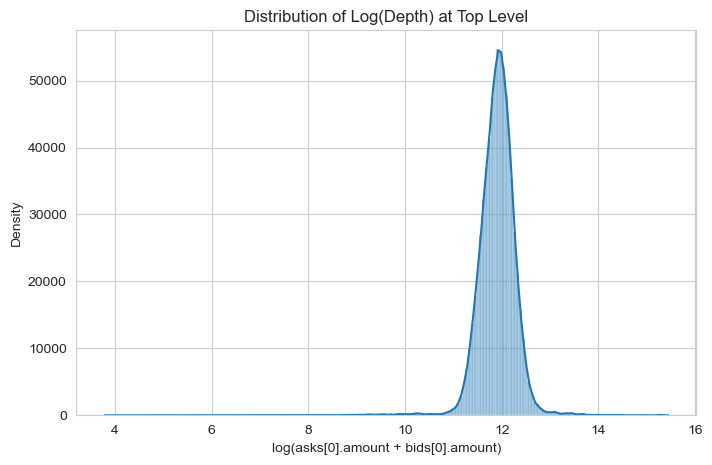

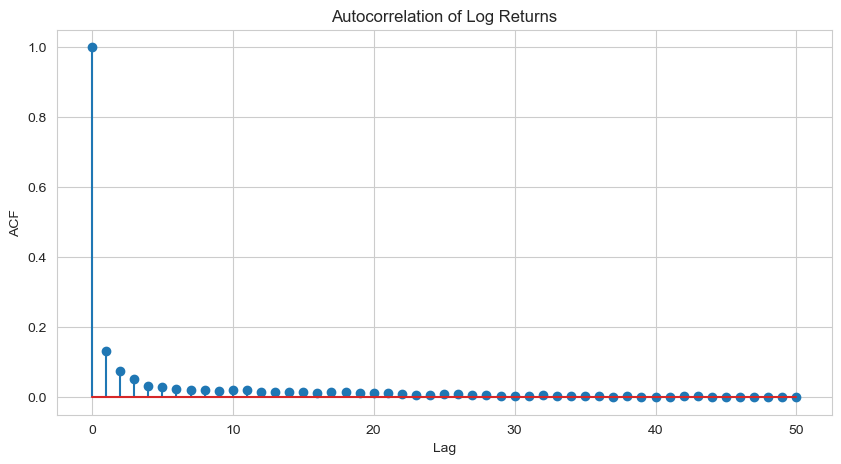

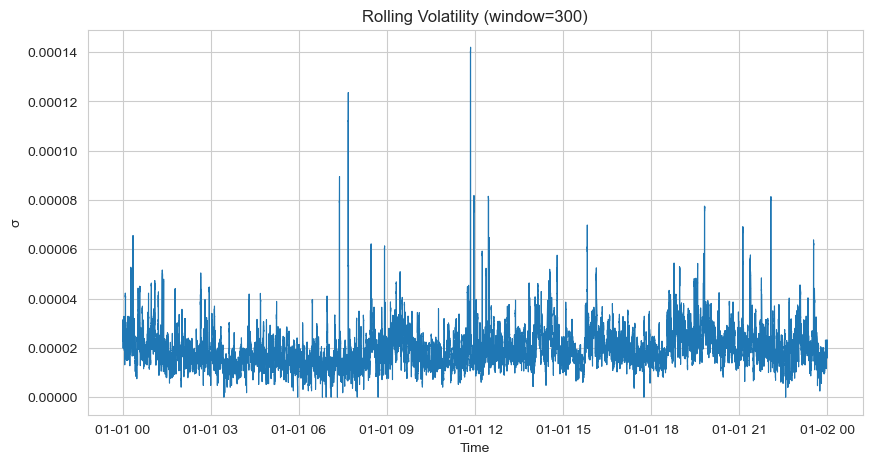

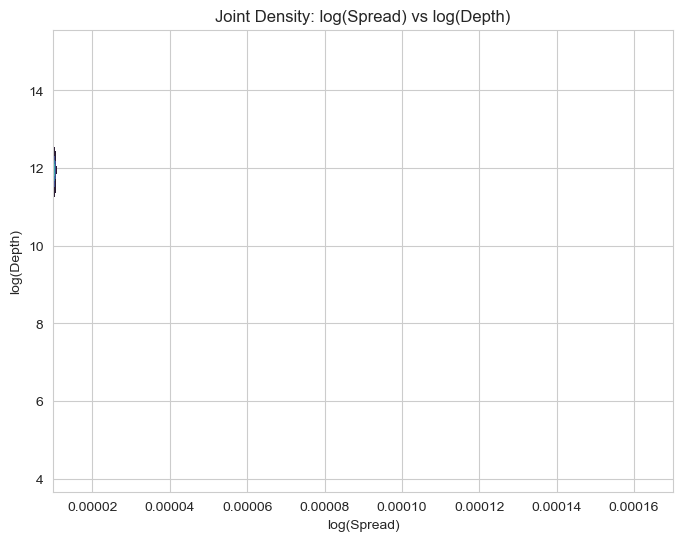

In [19]:
# ============================================
# Empirical Densities and Statistical Plots (Zhang Mian-style)
# ============================================

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
from scipy import stats

# sns.set_style("whitegrid")

# Ensure we have returns, spreads, depth columns
df["return"] = df["midprice"].pct_change()
df["log_return"] = np.log(df["midprice"]).diff()
df["depth_top"] = df["asks[0].amount"] + df["bids[0].amount"]

# --------------------------------------------
# 1. MIDPRICE EVOLUTION
# --------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(df["datetime"], df["midprice"], linewidth=0.8)
plt.title("Midprice Evolution (DOGEUSDT)")
plt.xlabel("Time")
plt.ylabel("Midprice")
plt.show()

# --------------------------------------------
# 2. EMPIRICAL DENSITY OF LOG RETURNS
# --------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df["log_return"].dropna(), bins=300, kde=True, stat="density")
plt.title("Empirical Density of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Density")

# Overlay Normal PDF for comparison
mu, sigma = df["log_return"].mean(), df["log_return"].std()
x = np.linspace(df["log_return"].min(), df["log_return"].max(), 200)
plt.plot(x, stats.norm.pdf(x, mu, sigma), "r--", label="Normal PDF")
plt.legend()
plt.show()

# --------------------------------------------
# 3. QQ-PLOT OF LOG RETURNS
# --------------------------------------------
plt.figure(figsize=(6,6))
stats.probplot(df["log_return"].dropna(), dist="norm", plot=plt)
plt.title("QQ-Plot of Log Returns (Normal Reference)")
plt.show()

# --------------------------------------------
# 4. SPREAD DISTRIBUTION
# --------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df["spread"], bins=200, kde=True)
plt.title("Distribution of Bid-Ask Spread")
plt.xlabel("Spread")
plt.ylabel("Density")
plt.show()

# --------------------------------------------
# 5. DEPTH DISTRIBUTION
# --------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df["depth_top"]), bins=200, kde=True)
plt.title("Distribution of Log(Depth) at Top Level")
plt.xlabel("log(asks[0].amount + bids[0].amount)")
plt.ylabel("Density")
plt.show()

# --------------------------------------------
# 6. AUTOCORRELATION OF RETURNS
# --------------------------------------------
from statsmodels.tsa.stattools import acf

returns = df["log_return"].dropna()
acf_vals = acf(returns, nlags=50, fft=True)

plt.figure(figsize=(10,5))
plt.stem(acf_vals)
plt.title("Autocorrelation of Log Returns")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

# --------------------------------------------
# 7. VOLATILITY CLUSTERING (Rolling Std)
# --------------------------------------------
window = 300  # rolling window size (e.g. 5 minutes if 1Hz data)
df["rolling_vol"] = df["log_return"].rolling(window).std()

plt.figure(figsize=(10,5))
plt.plot(df["datetime"], df["rolling_vol"], linewidth=0.8)
plt.title(f"Rolling Volatility (window={window})")
plt.xlabel("Time")
plt.ylabel("σ")
plt.show()

# --------------------------------------------
# 8. JOINT DISTRIBUTION: SPREAD VS DEPTH
# --------------------------------------------
plt.figure(figsize=(8,6))
sns.kdeplot(
    x=np.log1p(df["spread"]),
    y=np.log1p(df["depth_top"]),
    fill=True, cmap="mako"
)
plt.title("Joint Density: log(Spread) vs log(Depth)")
plt.xlabel("log(Spread)")
plt.ylabel("log(Depth)")
plt.show()


Duration stats (s): min=0.05 median=0.0999999 mean=0.121037 max=2.4
Exponential fit: loc=0, scale=0.121037  ->  λ=8.26193 per second


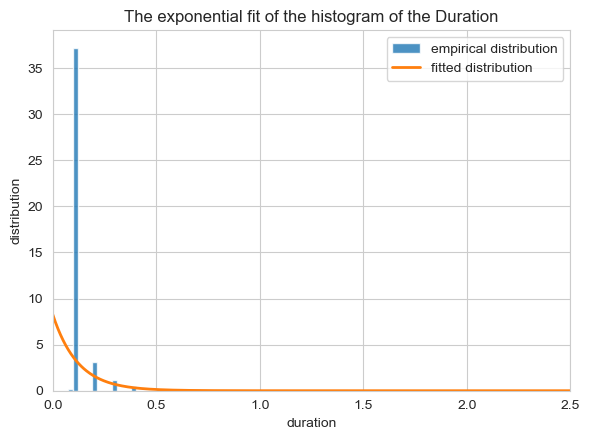

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- 1) durations in seconds (timestamps are in microseconds)
time_in_s = (df["timestamp"].astype(float) / 1e6).to_numpy()
durations = np.diff(time_in_s)
durations = durations[durations > 0]

# --- 2) (optional) inspect scale of your data
print(
    "Duration stats (s):",
    f"min={durations.min():.6g}",
    f"median={np.median(durations):.6g}",
    f"mean={durations.mean():.6g}",
    f"max={durations.max():.6g}",
)

# --- 3) fit exponential: MLE for loc and scale
# If you want to force the fit to start at 0 exactly, use: stats.expon.fit(durations, floc=0)
loc, scale = stats.expon.fit(durations, floc=0)  # loc≈0, scale = 1/λ
lam = 1.0 / scale
print(f"Exponential fit: loc={loc:.6g}, scale={scale:.6g}  ->  λ={lam:.6g} per second")

# --- 4) choose an x-range that shows the bulk of mass
p99 = np.percentile(durations, 99)          # trim extreme outliers
xmax = max(p99, 1e-3) * 5                   # a bit wider for visibility
x = np.linspace(0, xmax, 600)
y = stats.expon.pdf(x, loc=loc, scale=scale)

# --- 5) plot histogram + fitted exponential pdf (Zhang-Mian style)
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.hist(durations, bins=100, density=True, label="empirical distribution", alpha=0.8)
ax.plot(x, y, label="fitted distribution", linewidth=2)

ax.set_xlabel("duration")
ax.set_ylabel("distribution")
ax.set_title("The exponential fit of the histogram of the Duration")

# Use the classic fixed axis from the screenshot OR the auto one above.
# (uncomment ONE of the following):
# ax.set_xlim((0, 30)); ax.set_ylim((0, 0.2))     # original screenshot styling
ax.set_xlim((0, xmax)); ax.set_ylim(bottom=0)     # auto scaling for sub-second data

ax.legend()
plt.tight_layout()
plt.show()


Duration stats (s):
min=0.050000, max=2.400000, median=0.100000


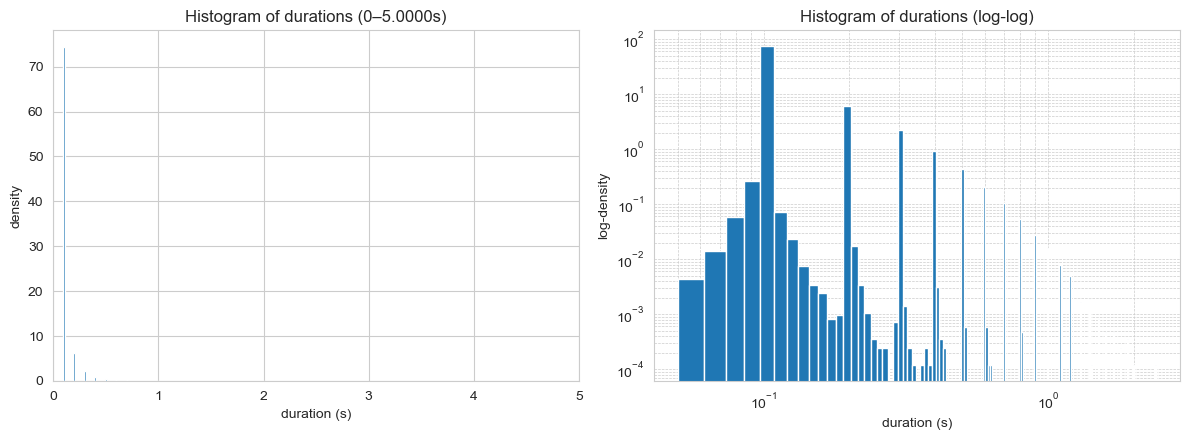

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Convert timestamps (µs → s)
time_in_s = (df["timestamp"].astype(float) / 1e6).to_numpy()

# --- 2) Compute positive durations
durations = np.diff(time_in_s)
durations = durations[durations > 0]

print("Duration stats (s):")
print(f"min={durations.min():.6f}, max={durations.max():.6f}, median={np.median(durations):.6f}")

# --- 3) Choose reasonable x-limits automatically
p99 = np.percentile(durations, 99)  # cut extreme outliers
xmax = max(p99, 1e-3) * 10  # a bit wider for visibility

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# (a) Linear scale
axes[0].hist(durations, bins=200, density=True)
axes[0].set_xlim((0, xmax))
axes[0].set_xlabel("duration (s)")
axes[0].set_ylabel("density")
axes[0].set_title(f"Histogram of durations (0–{xmax:.4f}s)")

# (b) Log-log scale
axes[1].hist(durations, bins=200, density=True, log=True)
axes[1].set_xlabel("duration (s)")
axes[1].set_ylabel("log-density")
axes[1].set_title("Histogram of durations (log-log)")
axes[1].set_xscale("log")
axes[1].grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()


Clean up

In [1]:
# ============================================
# EDA of Binance L2 Order Book Data (DOGEUSDT)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf

sns.set_style("whitegrid")

In [2]:
# -----------------------------
# 1. LOAD AND INITIAL INSPECTION
# -----------------------------
path = "D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
print("Columns:", df.columns[:10].tolist(), "...")
print(df.head())

# Ensure timestamps are numeric and sorted
df = df.sort_values("timestamp")
df["datetime"] = pd.to_datetime(df["timestamp"], unit="us")

Shape: (713815, 104)
Columns: ['exchange', 'symbol', 'timestamp', 'local_timestamp', 'asks[0].price', 'asks[0].amount', 'bids[0].price', 'bids[0].amount', 'asks[1].price', 'asks[1].amount'] ...
  exchange    symbol         timestamp   local_timestamp  asks[0].price  \
0  binance  DOGEUSDT  1735689601703988  1735689601703988        0.31601   
1  binance  DOGEUSDT  1735689601974000  1735689601975707        0.31601   
2  binance  DOGEUSDT  1735689602074000  1735689602075995        0.31601   
3  binance  DOGEUSDT  1735689602274000  1735689602275736        0.31601   
4  binance  DOGEUSDT  1735689602374000  1735689602375702        0.31601   

   asks[0].amount  bids[0].price  bids[0].amount  asks[1].price  \
0          126244          0.316           87917        0.31602   
1          126244          0.316           87917        0.31602   
2          126244          0.316           87917        0.31602   
3          115444          0.316           87917        0.31602   
4          115444   